# Building an Image Classifier from Scratch (Part 1)
This was a challenging post to create. It is based on the first half (or so) of Chapter 4 of the book "Practical Deep Learning for Coders". When I started, I fully intended to build the logo classifier from [this](https://jrbackon.github.io/fastbook/2025/02/28/premier-league-logo-classifier.html) post from scratch in one go. Instead, I ended up reading the chapter five times, and had to resort to ChatGPT to understand some of the nuances I was running into. While this post closely mimics the chapter in the book, there is one glaring difference which made it much harder. Color.

### Tensors and 4D Chess
Much of chapter 4 of PDLC is spent teaching the reader about pytorch tensors and the various operations that can be done with them. Tensors are objects that can be used to make the computer science parts of deep learning much easier. In my last post about gradient descent, I wanted to avoid using the pytorch or fastai libraries in the hopes that I would learn to appreciate them when I did. Now that I've gone through this exercise, I truly do appreciate the people who created this library and its usefulness. 

As I alluded to above, choosing color images to train a model was more difficult than I expected. The main reason for this was the limitation of my own experience. I am used to thinking of things in no more than 3 dimensions. A black and white image fits nicely into this model. Height and width represent two dimensions and then there is a number between 0 and 255 representing how black a given pixel is. In this way, each pixel can be described with 3 "coordinates" (x, y, darkness).

The images I used in the logo classifier are color which means that each pixel has 4 pieces of information: how much red, green, blue, and the transparency. So each pixel is "encoded" with 4 pieces of information (x, y, (RGBA)). This extra information broke my brain for a while and resulted in some of the challenges I will highlight below.

As a reminder. Here is an example of the images I will be attempting to classify.

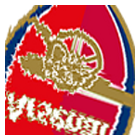

In [4]:
from fastai.vision.all import *

arsenal = Path("/Users/jbackon/Pictures/archive/epl-logos-big/epl-logos-big/arsenal").ls().sorted()
arsenal_path = arsenal[1]
im_arsenal = Image.open(arsenal_path)
im_arsenal

### Computer vision
Now, let's look at this image the way a computer "sees" it. To do this I convert the image to a tensor and display a small 5px by 5px section.

In [5]:
tensor(im_arsenal)[100:105,100:105]

tensor([[[227, 103, 138, 255],
         [233, 146, 172, 255],
         [234, 177, 189, 255],
         [232, 201, 198, 255],
         [232, 228, 210, 255]],

        [[202,  25,  55, 255],
         [210,  46,  83, 255],
         [217,  71, 106, 255],
         [223,  96, 129, 255],
         [229, 134, 159, 255]],

        [[195,   0,  36, 255],
         [198,   0,  40, 255],
         [201,   8,  45, 255],
         [204,  20,  56, 255],
         [211,  42,  80, 255]],

        [[201,   3,  56, 255],
         [198,   0,  47, 255],
         [196,   0,  35, 255],
         [193,   0,  29, 255],
         [195,   1,  33, 255]],

        [[202,   5,  57, 255],
         [201,   4,  56, 255],
         [200,   3,  54, 255],
         [200,   3,  53, 255],
         [200,   2,  52, 255]]], dtype=torch.uint8)

This output is a little strange, but makes sense once you understand what it is telling you. Each block of 5x4 represents one column of the 5px by 5px patch. So the first row of the first group tells you the information about the pixel in the top left of the 5x5 patch. The second row of the first group tells you the information about the pixel right below it, and the first row of the second group tells you the information about the pixel directly to the right of the top left corner. Each row contains (in order) a value for Red, Green, Blue, and what is known as the Alpha channel which dictates the images transparency. A value of 255 means the image is fully opaque.

One of the most important things to understand about tensors is their shape. The shape of the "im_arsenal" tensor is below. It tells us the dimensions of the image 140x140 and that each pixel contains 4 pieces of information. In other words we have (height, width, colors). The value of each category is called the size which will be important as we start "stacking" images in a moment.

In [6]:
tensor(im_arsenal).shape

torch.Size([140, 140, 4])

### A basic (mediocre) image classification model
Just like the book, I will be building a simple classification model. The model starts by finding the "ideal" logo by averaging each R,G,B and A value across all 1000 images. I will do this for two logo types. Then I will create a function that determines whether the average pixel values of a single image is closer to one ideal type or the other and use that to classify the image. It's not a great model, but it demonstrates some of the power of tensors and will make it look even cooler when I do it with a neural net.

Before I do anything, I need to ensure that all images in the folder are the same size. Pytorch comes with a "transform" module that allows me to do just that. 

In [17]:
import torch
import torchvision.transforms as transforms

target_size = (140, 140)
resize_tranform = transforms.Compose([transforms.Resize(target_size),transforms.ToTensor()])

arsenal_tensors = [resize_tranform(Image.open(o)) for o in arsenal]

arsenal_tensors[12].shape

torch.Size([4, 140, 140])

You probably noticed the order of the values in the tensor changed after the transformation. As far as the computer is concerned, it doesn't care what order the information is presented. It DOES matter for different methods in pytorch or fastai. More on this later when it comes up.

I have created a list of tensors with all 1000 images. Here is an example image:

1000


<Axes: >

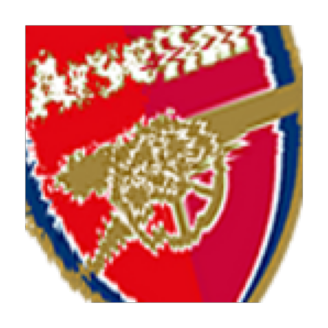

In [13]:
print(len(arsenal_tensors))
show_image(arsenal_tensors[12])

I am now going to "stack" all of the images in the above list into a single tensor. This is one of the many advantage of using the pytorch library. With stock python I would have to use a for loop to iterate through the objects in the list. Using tensors, I can treat all 1000 images as a single object without losing any of the information. 

The .float()/255 converts all of the pixel values to a float and then normalizes them to between 0 and 1 since 255 is the maximum value of any of the color categories. Many of the methods used below require tensor values between 0 and 1 which is why this step is necessary.

In [65]:

stacked_arsenal = torch.stack(arsenal_tensors).float()/255
stacked_arsenal.shape

torch.Size([1000, 4, 140, 140])

The shape of the stacked tensor now includes a value for the number of images. So we have 1000 140px by 140px images and 4 pieces of information in each pixel. I'm not sure if this concept is obvious or not, but the difference between (4, 140, 140) and (1000, 4, 140, 140) is not just one number. It's easily represented as one numnber, but the stacked tensor literally contains all of the color information for all 1000 images. Imagine trying to capture this information with standard python lists or dictionaries. Actually, don't do that.

Now we need to create the "ideal" version of the Arsenal logo. To do this we will average all of the red values across all 1000 images and then do the same for the other colors. Once I do this I will have a new tensor of shape 3.

In [15]:
mean_arsenal = stacked_arsenal.mean(dim=0)
mean_arsenal.shape

torch.Size([4, 140, 140])

I wanted to see what the ideal Arsenal logo looked like. Earlier, I was just displaying an image with the "Image" method. Now, I have a tensor containing RGBA values and am essentially "plotting" the values of each pixel onto a coordinate plane. I used ChatGPT to help with this part, and it recommended using matplotlib and numpy. There is probably a way to do this with pytorch or fastai, but I don't know it yet. 

The methods I used here require the tensor to have a shape of (height, width, colors) and so I had to permute, or change the order, of the represented information. This is a requirement of the specific method and doesn't say anything special about the tensor I am displaying. The method also requires the information to be normalized between 1 and 0 which I do with numpy.

When all is said and done you can see the "ideal" Arsenal logo.

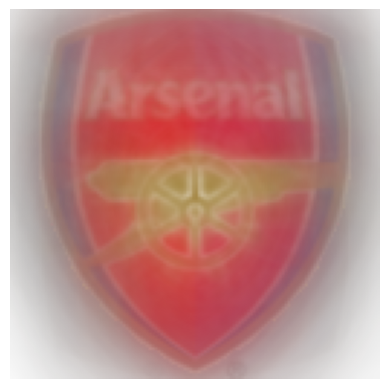

In [ ]:
# for the purposes of displaying the image
import matplotlib.pyplot as plt

# the image renderer is expecting (H, W, C) or (128,128,4)
ideal_arsenal = mean_arsenal.permute(1, 2, 0)

ideal_arsenal = ideal_arsenal.numpy()
# image normalization required for numpy to render the image correctly
ideal_arsenal = (ideal_arsenal - ideal_arsenal.min()) / (ideal_arsenal.max() - ideal_arsenal.min())

plt.imshow(ideal_arsenal)
plt.axis("off")
plt.show()

I was pretty impressed with this since I know that many of the images in the set are upside down or skewed in some way. Even with all of those variations, average pixel values still give you a pretty "clear" version of the Arsenal logo. In this case, "clear" is defined as a blurry representation of the logo I love, but I'll take it.

In order to build my mediocre image classifier I need to be able to determine whether a single images' rgb values are closer to this ideal image or another. So, given that Liverpool are the top team right now, and their logo has some similar features to the Arsenal logo, I chose it for my comparison.

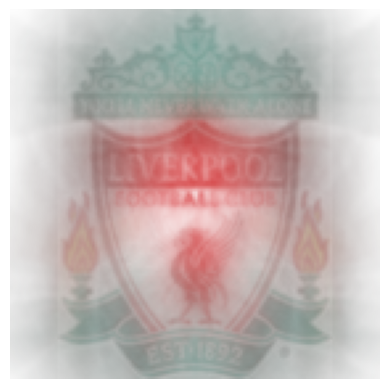

In [21]:
liverpool = Path("/Users/jbackon/Pictures/archive/epl-logos-big/epl-logos-big/liverpool").ls().sorted()

liverpool_tensors = torch.stack([resize_tranform(Image.open(o)) for o in liverpool])
liverpool_tensors = liverpool_tensors.float()/255

mean_liverpool = liverpool_tensors.mean(dim=0)

liverpool_permute = mean_liverpool.permute(1, 2, 0)

ideal_liverpool = liverpool_permute.numpy()
ideal_liverpool = (ideal_liverpool - ideal_liverpool.min()) / (ideal_liverpool.max() - ideal_liverpool.min())

plt.imshow(ideal_liverpool)
plt.axis("off")
plt.show()



### Building the model
Now that we have our "ideal" version of the Arsenal and Liverpool logos, we need to determine how to classify a single version of these logos. Just like if we were fitting a curve, we are interested in how "far" our RGBA values are from the ideal logo at each pixel. So, we will simply subtract one of our logos from the ideal and take the absolute value or the square root of the square to account for possible negative "distances".

In [19]:
dist_ars_abs = (stacked_arsenal[12] - mean_arsenal).abs().mean()
dist_ars_sqr = ((stacked_arsenal[12] - mean_arsenal)**2).mean().sqrt()
dist_ars_abs, dist_ars_sqr

(tensor(0.0009), tensor(0.0011))

Both methods give similar results for the same image. Now, we will do the same for a liverpool logo. These operations are so common that fastai has built in methods to do the calculation. I used them below.

In [22]:
dist_liv_abs = F.l1_loss(liverpool_tensors[12],mean_liverpool)
dist_liv_sqr = F.mse_loss(liverpool_tensors[12],mean_liverpool).sqrt()
dist_liv_abs, dist_liv_sqr

(tensor(0.0010), tensor(0.0013))

These distances are pretty close to the ones from the Arsenal logo, but should be different enough to allow us to build our cheap classifier using a simple comparison. 

I will not be "training" this model in the deep learning sense so there is no need to save some of the images for a validation set. Regardless, the book suggests it is good practice to do this anyway, and so I will be splitting the original set of images into a "training" and "validation" set. This also provides the opportunity to explain broadcasting and further demonstrate the "power" of tensors. The code below uses a method from the sklearn library that does the split. I used this in my anomaly detection project and so I'm already familiar with it.

In [23]:
from sklearn.model_selection import train_test_split

ars_train, ars_valid = train_test_split(arsenal, test_size=0.2, random_state=42)

liv_train, liv_valid = train_test_split(liverpool, test_size=0.2, random_state=42)

Now I will stack the 4 objects into a tensor in preparation for my comparison. It's kind of neat to see that, if I'm not interested in viewing the images, I can create a stacked tensor of normalized images in just two lines of code. The resulting shape shows that I have 800 images in my training set. I'm not actually going to use these tensors so this step was unnecessary, but I'm trying to build good habits.

In [208]:
ars_train_tensors = torch.stack([resize_tranform(Image.open(o)) for o in ars_train])
ars_train_tensors = ars_train_tensors.float()/255


liv_train_tensors = torch.stack([resize_tranform(Image.open(o)) for o in liv_train])
liv_train_tensors = liv_train_tensors.float()/255

ars_train_tensors.shape, liv_train_tensors.shape

(torch.Size([800, 4, 128, 128]), torch.Size([800, 4, 128, 128]))

I'm now going to do the same stacking for my "validation" sets. These are the tensors I will use to "build" my model and determine how "good" it is. 

In [25]:
ars_valid_tensors = torch.stack([resize_tranform(Image.open(o)) for o in ars_valid])
ars_valid_tensors = ars_valid_tensors.float()/255

liv_valid_tensors = torch.stack([resize_tranform(Image.open(o)) for o in liv_valid])
liv_valid_tensors = liv_valid_tensors.float()/255
ars_valid_tensors.shape, liv_valid_tensors.shape

(torch.Size([200, 4, 140, 140]), torch.Size([200, 4, 140, 140]))

This next part gets a little tricky and is where I spent a lot of time trying to determine if I was doing any of this right. I created a function that will return the mean absolute distance between two images. You will notice the "mean" function has specific indices it is calling. The -1 and -2 correspond to the last and second to last axis of the tensor or (140, 140). This ensures that the function is taking the mean absolute value over the last two values which represent a single pixel in the image. Remember, that each pixel has 4 pieces of information "encoded" in it and so the function will automatically know to subtract each set of values (red-red, green-green, etc.) for each pixel.

In [31]:
def logo_distance(a,b): return (a-b).abs().mean((-1, -2))
logo_distance(ars_valid_tensors[12], mean_arsenal)

tensor([0.0014, 0.0008, 0.0008, 0.0018])

This is not the only way to do this. I could also average the 4 RGBA values, and *then* do the subtraction. This is actually the method I started with when I first went through this exercise. When creating the ideal Arsenal logo, I averaged the RGBA values of each pixel of each image and then took the average of those values. This resulted in code that looked more like the book which does all of this with black and white images. When I displayed the "ideal" arsenal logo using this method I got something rather strange. Let me show you:

<Axes: >

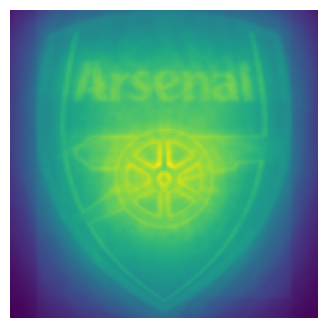

In [96]:
weird_average = stacked_arsenal.mean(1)
show_image(weird_average.mean(0))

While this image has the correct shape, the colors are way off. This is due to the fact that I averaged all of the RGBA values together to get a single value that the "show_image" method is attempting to render. I suspect that doing this would produce the same results I get below as long as I did the same averaging for my validation set. The relative "distances" from a single image to the ideal image should be preserved, but doing it this way feels wrong. Ultimately, I want to build a neural net that trains a model to be able to identify any Arsenal logo. In order to do this, I need to be able to tell the model what an Arsenal logo looks like, and this version just isn't a true Arsenal logo. So, in the interest of preparing for the future, I am going to use the ideal image with the RGBA values preserved.

### Broadcasting
I am now going to use my "logo_distance" function to calculate the absolute mean distance from the ideal Arsenal image for *each* image in my validation set. There is a subtly powerful operation happening here. My "ars_valid_tensors" tensor has a shape of (200,4,140,140) and the "mean_arsenal" tensor has a shape of (4,140,140). In other words I am asking the function to subtract the RGBA values from one 140x140 image from the 200 images in my validation set. Using stock python I would have to do this with a for loop and it would be very slow in computer time. Tensors have the ability to do this very quickly with an operation called "broadcasting". "Broadcasting" takes tensors of different shapes and allows you to operate on them as if they were the same shape. In this way, the "logo_distance" function "knows" to take the one set of RGBA values from "mean_arsenal" and subtract them from each of the averaged RGBA values from each image in the validation set. 

*Note: remember that the averaged RGBA values are all of the red values for every pixel averaged together, and all of the green values for every pixel averaged together etc.*

In [257]:
ars_valid_distance = logo_distance(ars_valid_tensors, mean_arsenal)
ars_valid_distance, ars_valid_distance.shape

(tensor([[0.0007, 0.0007, 0.0006, 0.0008],
         [0.0010, 0.0010, 0.0008, 0.0012],
         [0.0011, 0.0008, 0.0007, 0.0014],
         [0.0011, 0.0008, 0.0007, 0.0014],
         [0.0008, 0.0008, 0.0006, 0.0009],
         [0.0011, 0.0008, 0.0007, 0.0015],
         [0.0008, 0.0007, 0.0006, 0.0009],
         [0.0007, 0.0007, 0.0005, 0.0008],
         [0.0008, 0.0010, 0.0007, 0.0009],
         [0.0007, 0.0007, 0.0005, 0.0008],
         [0.0007, 0.0007, 0.0005, 0.0008],
         [0.0010, 0.0009, 0.0007, 0.0010],
         [0.0014, 0.0008, 0.0007, 0.0018],
         [0.0016, 0.0008, 0.0008, 0.0020],
         [0.0012, 0.0010, 0.0007, 0.0013],
         [0.0008, 0.0008, 0.0006, 0.0008],
         [0.0011, 0.0011, 0.0008, 0.0013],
         [0.0012, 0.0008, 0.0007, 0.0015],
         [0.0016, 0.0008, 0.0008, 0.0021],
         [0.0010, 0.0008, 0.0007, 0.0012],
         [0.0009, 0.0010, 0.0008, 0.0010],
         [0.0008, 0.0008, 0.0006, 0.0008],
         [0.0012, 0.0008, 0.0007, 0.0016],
         [0

Hopefully, the shape of the resulting tensor (200,4) makes sense. It contains the absolute mean distance from the ideal Arsenal logo for each RGBA value for each image in the validation set.

### The classifier
It turns out that the average distance from the ideal Arsenal logo was *often* smaller than the average distance from the ideal Liverpool logo. So, just like the classifier in the PDLC book, I am going to create a function called "is_arsenal" that simply returns a boolean depending on if the average distance of an image to the ideal Arsenal is less than that of an ideal Liverpool.

In [97]:
def is_arsenal(x): return logo_distance(x,mean_arsenal) < logo_distance(x,mean_liverpool)

is_arsenal(stacked_arsenal[12])

tensor([True, True, True, True])

And there we have it! I have successfully classified an image from the original set of Arsenal logos. Or, more specifically, I have determined that the average RGBA values for this image are closer to the ideal Arsenal logo than the ideal Liverpool logo.

How "good" is this model though? It would be nice if I had some metric to report that easily shows how well this model performs. To do this I need to capture how accurate the model is. Accuracy is something that humans understand very well. The first thing I need to do is run the model on my entire validation set for the Arsenal logos.

In [260]:
is_arsenal(ars_valid_tensors)

tensor([[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [False,  True,  True, False],
        [False,  True,  True, False],
        [ True,  True,  True,  True],
        [False,  True,  True, False],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [False,  True,  True, False],
        [False,  True,  True, False],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [False,  True,  True, False],
        [False,  True,  True, False],
        [ True,  True,  True, False],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [False,  True,  True, False],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [False,  True,  True, False],
        [ Tr

You will notice that, in some cases, the average pixel values are *not* closer to the ideal Arsenal logo. This would represent an area where the model does not perform well. To represent this in terms of accuracy I am going to convert each boolean to a float of 1 or 0 where 1 represents True and 0 represents False. Then I will average all of these values together and this will give me the percentage of values that the model got right or the accuracy of the model.

In [264]:
accuracy_ars = is_arsenal(ars_valid_tensors).float().mean()
accuracy_liv = (1 - is_arsenal(liv_valid_tensors).float()).mean()

accuracy_ars, accuracy_liv, (accuracy_ars+accuracy_liv)/2

(tensor(0.8625), tensor(0.7650), tensor(0.8138))

As you can see, this particular model can classify an Arsenal logo with 86% accuracy and a Liverpool logo with 77% accuracy. The average accuracy of the model as a whole is 81%.

So, here is a mediocre image classifier. It may work well enough for some purposes, but I think I can do better. Or, more specifically, I think I can create a neural net that can "learn" how to do this better. That will be the focus of my next post. Wish me luck!